# TensorBoard
- Analysing your data and network
- Live updates to accuracy and loss
- precesion recall (PR) curve

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transorms
import matplotlib.pyplot as plt

import torch.nn.functional as F

In [5]:
import sys
from torch.utils.tensorboard import SummaryWriter

In [6]:
writer = SummaryWriter("runs/mnist")

epoch 1 / 4, step 100 / 600, loss = 0.3251
epoch 1 / 4, step 200 / 600, loss = 0.3053
epoch 1 / 4, step 300 / 600, loss = 0.2466
epoch 1 / 4, step 400 / 600, loss = 0.3427
epoch 1 / 4, step 500 / 600, loss = 0.3433
epoch 1 / 4, step 600 / 600, loss = 0.2716
epoch 2 / 4, step 100 / 600, loss = 0.2506
epoch 2 / 4, step 200 / 600, loss = 0.2674
epoch 2 / 4, step 300 / 600, loss = 0.4236
epoch 2 / 4, step 400 / 600, loss = 0.1645
epoch 2 / 4, step 500 / 600, loss = 0.2341
epoch 2 / 4, step 600 / 600, loss = 0.1120
epoch 3 / 4, step 100 / 600, loss = 0.2127
epoch 3 / 4, step 200 / 600, loss = 0.1155
epoch 3 / 4, step 300 / 600, loss = 0.0963
epoch 3 / 4, step 400 / 600, loss = 0.1601
epoch 3 / 4, step 500 / 600, loss = 0.1660
epoch 3 / 4, step 600 / 600, loss = 0.1940
epoch 4 / 4, step 100 / 600, loss = 0.1789
epoch 4 / 4, step 200 / 600, loss = 0.1085
epoch 4 / 4, step 300 / 600, loss = 0.1615
epoch 4 / 4, step 400 / 600, loss = 0.0392
epoch 4 / 4, step 500 / 600, loss = 0.0887
epoch 4 / 4

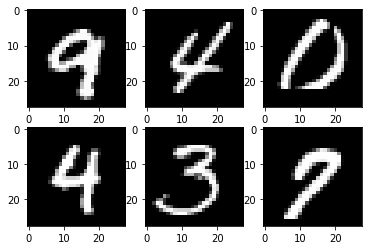

In [18]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
# 10 different classes
num_classes = 10 

# training epochs
num_epochs = 4
batch_size = 100
learning_rate = 0.001

#MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          transform=transorms.ToTensor(),
                                          download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transorms.ToTensor())

# dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size,
                                          shuffle=False) 
# shuffle false b/c doesn't matter for eval

examples = iter(train_loader)
example_data, example_targets = examples.next()
#print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')

img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)

writer.close() # flush

#sys.exit() # exit system before training occurs

# setting up a fully connected NN with one hidden layer

class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) # first layer
        self.relu = nn.ReLU() # activation layer
        self.l2 = nn.Linear(hidden_size, num_classes) # second layer
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out) # no soft max here
        return out

# model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss() # this will apply the soft max, which is why it was not needed earlier
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, example_data.reshape(-1, 28*28))
writer.close()
#|sys.exit()


# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    # loop over batches
    for i, (images, labels) in enumerate(train_loader):
        # reshape images first from 100, 1, 28, 28 ->
        # input size = 784 
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() # update step, updating parameters
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0


labels = []
preds = []
            
# testing loop and evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    # loop over batches in test samples
    for images, labels1 in test_loader:
        # reshape
        images = images.reshape(-1, 28*28).to(device)
        labels1 = labels1.to(device)
        outputs = model(images)
        
        # value, index -> returned by torch.max
        _, predictions = torch.max(outputs, 1)
        n_samples += labels1.shape[0] # gives the number of samples in current batch
        n_correct += (predictions == labels1).sum().item()
        
        labels.append(predictions)
        # call softmax explicitly for output
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
    
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels = torch.cat(labels) # concatenate all elements in the list to 1d tensor
    
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')
    
    classes = range(10)
    for i in classes:
        labels_i = labels == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()